In [590]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier



#Shrek6


In [591]:
column_name_mapping = {
    "filename": "Track_Name",
    "length": "Duration",
    "chroma_stft_mean": "Average_Note_Intensity",
    "chroma_stft_var": "Note_Intensity_Variability",
    "rms_mean": "Loudness_Average",
    "rms_var": "Loudness_Variability",
    "spectral_centroid_mean": "Brightness_Average",
    "spectral_centroid_var": "Brightness_Variability",
    "spectral_bandwidth_mean": "Sound_Richness_Average",
    "spectral_bandwidth_var": "Sound_Richness_Variability",
    "rolloff_mean": "Bass_to_Treble_Balance_Average",
    "rolloff_var": "Bass_to_Treble_Balance_Variability",
    "zero_crossing_rate_mean": "Percussiveness_Average",
    "zero_crossing_rate_var": "Percussiveness_Variability",
    "harmony_mean": "Harmonic_Content_Average",
    "harmony_var": "Harmonic_Content_Variability",
    "perceptr_mean": "Sharpness_Average",
    "perceptr_var": "Sharpness_Variability",
    "tempo": "Tempo",
    # MFCCs grouped
    **{f"mfcc{i}_mean": f"MFCC{i}_Average" for i in range(1, 21)},
    **{f"mfcc{i}_var": f"MFCC{i}_Variability" for i in range(1, 21)},
    "label": "Genre"
}


In [592]:
path = "D:/Coding/VS/Projects/Audio Genres/features_30_sec.csv/features_30_sec.csv"
data = pd.read_csv(path)

data_labeled = data.rename(columns=column_name_mapping)
data_labeled = data_labeled.drop(columns="Duration")
data_labeled.isnull().sum() 

scaler = StandardScaler()
le = LabelEncoder()

# Replace labels for rock and metal as they are often being confused + logically close
data_labeled["Genre"] = data_labeled["Genre"].replace({"rock": "rock_metal", "metal": "rock_metal"})


data_labeled["Genre"] = le.fit_transform(data_labeled["Genre"])


X = data_labeled.iloc[:, 1:-1]
y = data_labeled["Genre"]





In [593]:
genre_mapping = {index: label for index, label in enumerate(le.classes_)}
print("Encoded Labels:", genre_mapping)

Encoded Labels: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'pop', 7: 'reggae', 8: 'rock_metal'}


In [594]:
# for col in data_labeled.columns[1:-1]:
#     plt.figure(figsize=(8, 4))
#     sns.boxplot(x=data_labeled["Genre"], y=data_labeled[col])
#     plt.title(f"Boxplot of {col} by Genre")
#     plt.xlabel("Genre")
#     plt.ylabel(col)
#     plt.show()


<Axes: >

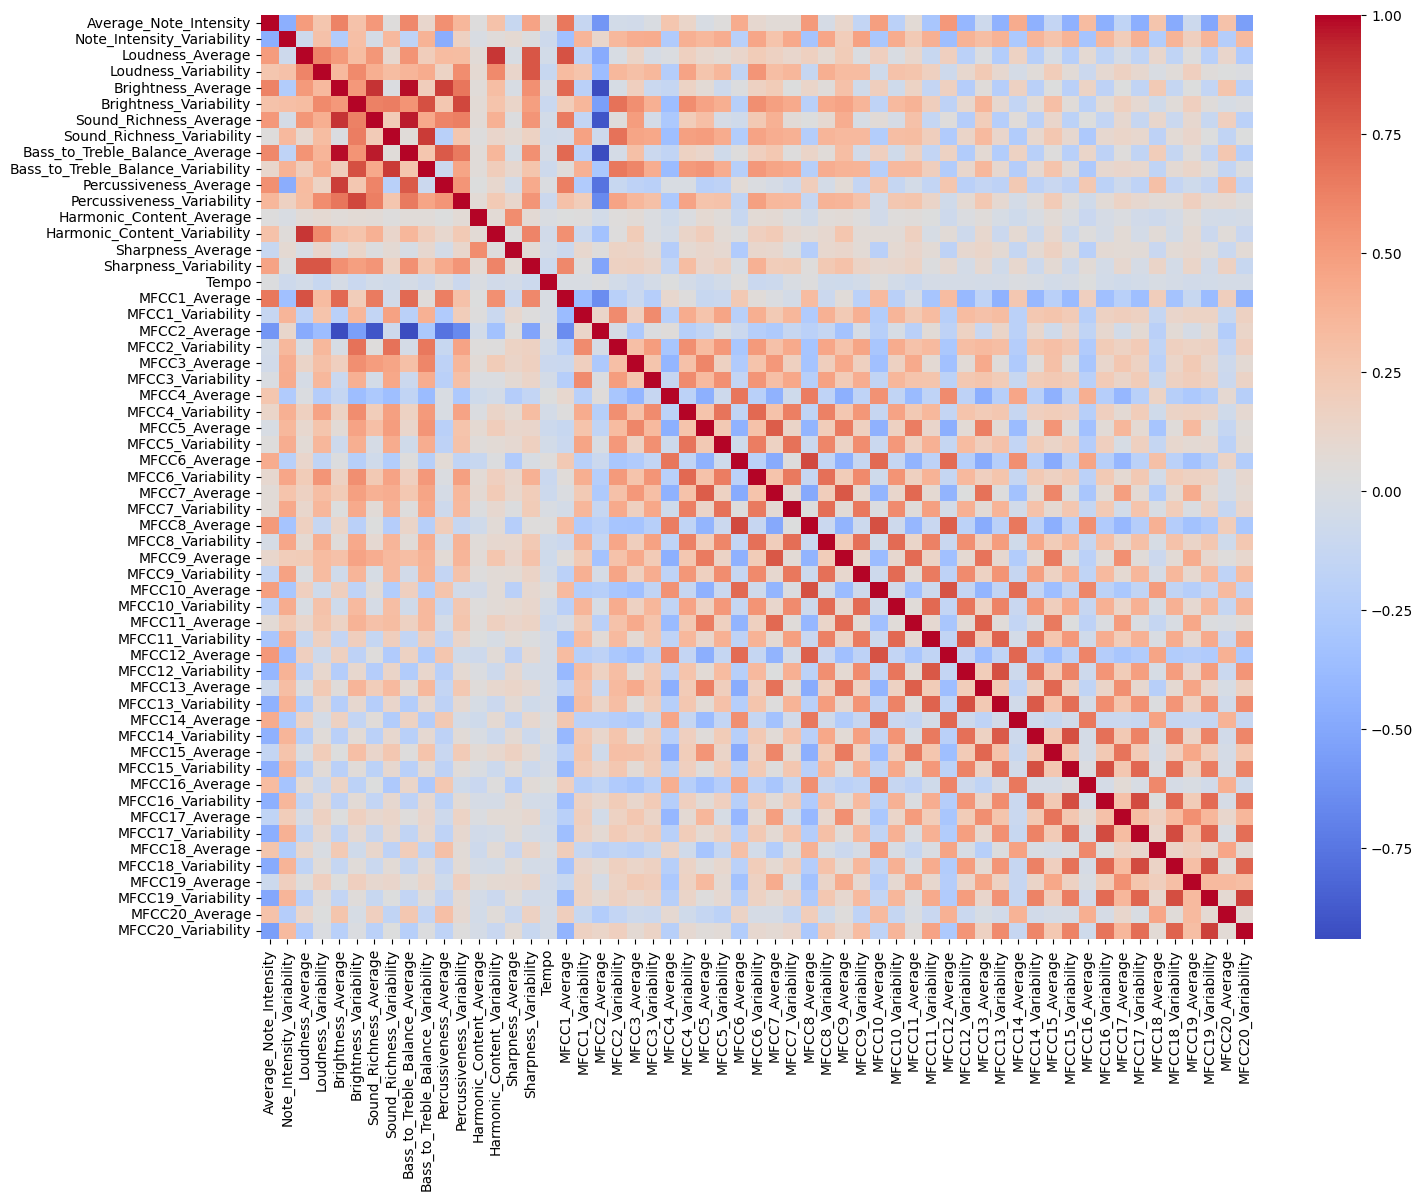

In [595]:
correlation_matrix = X.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm")


In [596]:

# Find highly correlated features
high_corr_pairs = np.where(((correlation_matrix > 0.9) | (correlation_matrix < -0.9)) & (correlation_matrix != 1.0))
correlated_features = [(correlation_matrix.index[x], correlation_matrix.columns[y]) for x, y in zip(*high_corr_pairs)]

correlated_features_df = pd.DataFrame(correlated_features, columns=['Feature 1', 'Feature 2'])
correlated_features_df

,Feature 1,Feature 2
0,Brightness_Average,Sound_Richness_Average
1,Brightness_Average,Bass_to_Treble_Balance_Average
2,Brightness_Average,MFCC2_Average
3,Sound_Richness_Average,Brightness_Average
4,Sound_Richness_Average,Bass_to_Treble_Balance_Average
5,Bass_to_Treble_Balance_Average,Brightness_Average
6,Bass_to_Treble_Balance_Average,Sound_Richness_Average
7,Bass_to_Treble_Balance_Average,MFCC2_Average
8,MFCC2_Average,Brightness_Average
9,MFCC2_Average,Bass_to_Treble_Balance_Average


In [597]:
random_state_holder = 38

X_uncor = X.drop(columns=['MFCC2_Average','Brightness_Average','Sound_Richness_Average' ])
X_uncor_scaled = scaler.fit_transform(X_uncor)
X_train, X_test, y_train, y_test = train_test_split(X_uncor_scaled, y, test_size=0.2, stratify=y, random_state=random_state_holder) # stratify=y might lead to overfitting


In [598]:
param_grid_knn = {
    'n_neighbors': list(range(1, 20)), 
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan']
}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=8, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

print("Best Parameters:", grid_search_knn.best_params_)


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}


In [599]:

param_grid_rf = {
    'n_estimators': [250, 300, 350, 500],        # Increase the number of trees
    'max_depth': [10, 15, 20],       # Allow deeper trees or no limit
    'min_samples_split': [2, 5, 10],       # Reduce regularization
    'min_samples_leaf': [1, 2 ,4]          # Allow smaller leaf sizes
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=8, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_


print("Best Random Forest Parameters:", grid_search_rf.best_params_)


Best Random Forest Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}


In [600]:

# Define the parameter grid
param_grid_svm = {
    'C': [ 0.1, 1, 7, 10,15, 20],        
    'gamma': [1, 0.1, 0.01, 0.001],    
    'kernel': ['rbf'], 
    'degree': [1, 2, 3]           
}

# Grid search with cross-validation
grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=8, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_


print("Best Parameters:", grid_search_svm.best_params_)



Best Parameters: {'C': 20, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [601]:

param_grid_xgb = {
    'n_estimators': [200, 300, 350],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.6, 0.8],

}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier( eval_metric='mlogloss'),
    param_grid=param_grid_xgb,
    cv=8,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

print("Best XGBoost Parameters:", grid_search_xgb.best_params_)


Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}


In [602]:
y_pred_knn = best_knn.predict(X_test)
y_pred_rf = best_rf.predict(X_test)
y_pred_svm = best_svm.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)


print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print()
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))



KNN Accuracy: 0.685
Random Forest Accuracy: 0.72
SVM Accuracy: 0.76
XGBoost Accuracy: 0.755

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.55      0.67        20
           1       0.90      0.90      0.90        20
           2       0.67      0.80      0.73        20
           3       0.50      0.65      0.57        20
           4       0.61      0.55      0.58        20
           5       0.75      0.60      0.67        20
           6       0.72      0.90      0.80        20
           7       0.54      0.35      0.42        20
           8       0.69      0.78      0.73        40

    accuracy                           0.69       200
   macro avg       0.69      0.68      0.67       200
weighted avg       0.69      0.69      0.68       200

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.50      0.65        20
           1       0.86    

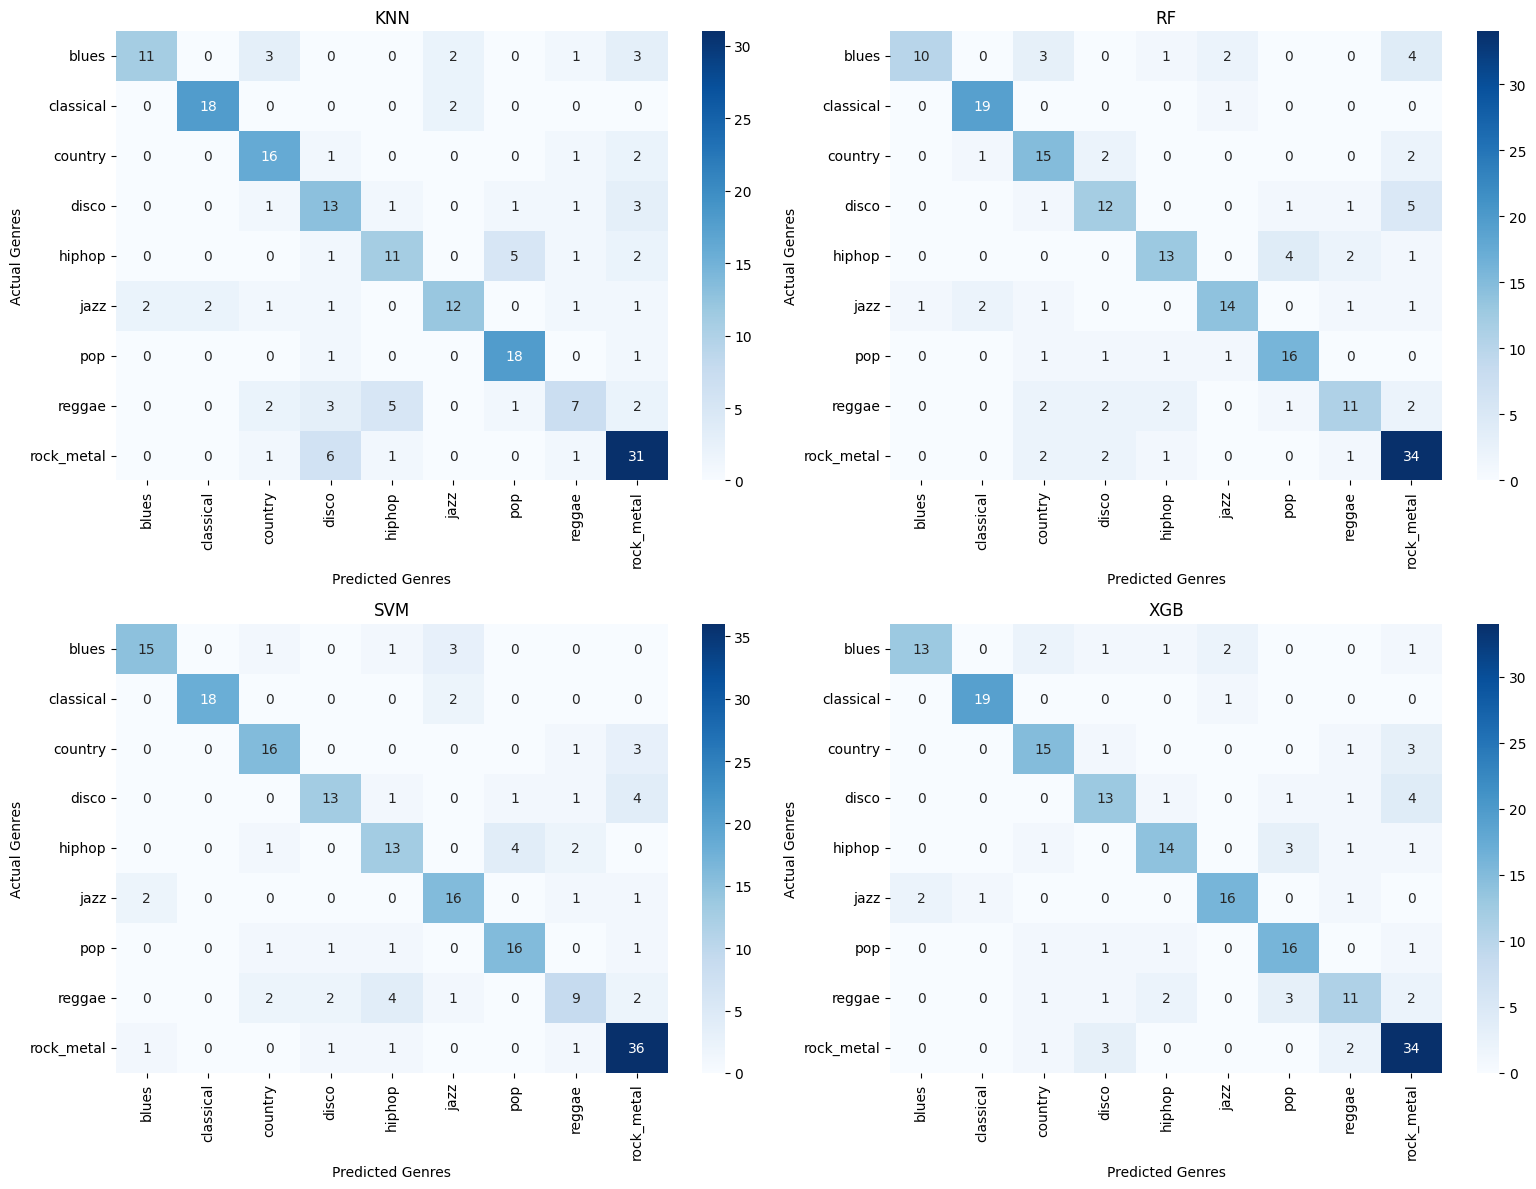

In [603]:
# Create confusion matrices and check the results of different models

predictions = [y_pred_knn, y_pred_rf, y_pred_svm, y_pred_xgb]
titles = ["KNN", "RF", "SVM", "XGB"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for ax, y_pred, title in zip(axes.ravel(), predictions, titles):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted Genres")
    ax.set_ylabel("Actual Genres")

plt.tight_layout()
plt.show()


In [604]:
# Predictions are not too precise, let's see what features are the most important for the predictions

In [605]:
random_states = range(30, 40)
for model in [best_knn, best_rf, best_svm, best_xgb]:
    for state in random_states:
        X_train, X_test, y_train, y_test = train_test_split(X_uncor_scaled, y, test_size=0.2, stratify=y, random_state=state) # stratify=y might lead to overfitting
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Random State {state}, {model.__class__.__name__} Accuracy: {accuracy_score(y_test, y_pred):.4f}")



Random State 30, KNeighborsClassifier Accuracy: 0.7050
Random State 31, KNeighborsClassifier Accuracy: 0.7250
Random State 32, KNeighborsClassifier Accuracy: 0.7150
Random State 33, KNeighborsClassifier Accuracy: 0.7350
Random State 34, KNeighborsClassifier Accuracy: 0.6950
Random State 35, KNeighborsClassifier Accuracy: 0.7000
Random State 36, KNeighborsClassifier Accuracy: 0.7000
Random State 37, KNeighborsClassifier Accuracy: 0.7200
Random State 38, KNeighborsClassifier Accuracy: 0.6850
Random State 39, KNeighborsClassifier Accuracy: 0.7550
Random State 30, RandomForestClassifier Accuracy: 0.7400
Random State 31, RandomForestClassifier Accuracy: 0.7650
Random State 32, RandomForestClassifier Accuracy: 0.6800
Random State 33, RandomForestClassifier Accuracy: 0.7250
Random State 34, RandomForestClassifier Accuracy: 0.7300
Random State 35, RandomForestClassifier Accuracy: 0.7050
Random State 36, RandomForestClassifier Accuracy: 0.7400
Random State 37, RandomForestClassifier Accuracy: 0

In [610]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('svc', best_svm),
    ('knn', best_knn)
], voting='soft', weights=[1, 2, 2, 1])

ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)

print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))



Ensemble Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.75      0.83        20
           1       0.94      0.85      0.89        20
           2       0.86      0.90      0.88        20
           3       0.71      0.75      0.73        20
           4       0.70      0.70      0.70        20
           5       0.78      0.90      0.84        20
           6       0.75      0.90      0.82        20
           7       0.73      0.80      0.76        20
           8       0.94      0.82      0.88        40

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



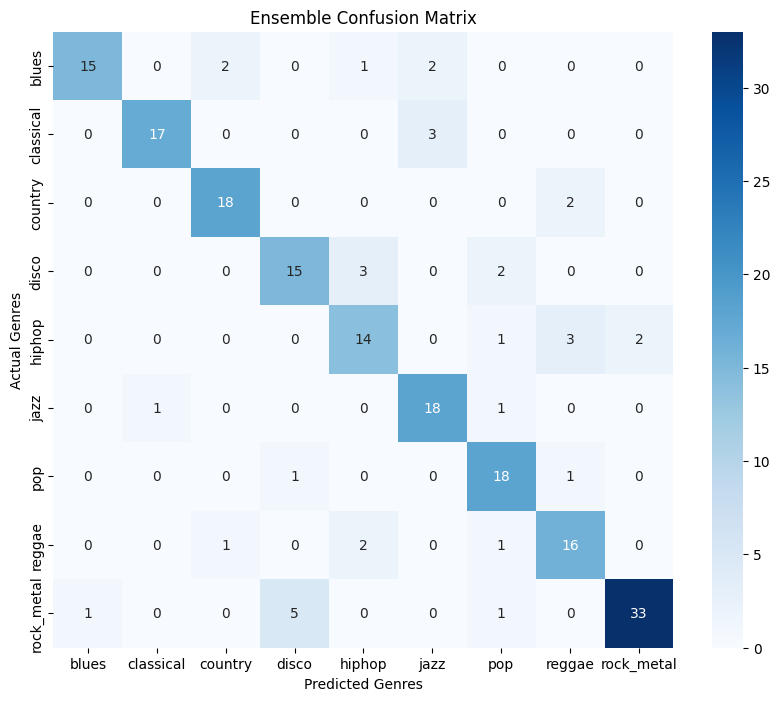

In [607]:
cm = confusion_matrix(y_test, y_pred_ensemble)  

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted Genres")
plt.ylabel("Actual Genres")
plt.show()
